In [9]:
import numpy as np
import pandas as pd

In [10]:
dataset_path = '../../datasets/AEP_hourly.csv'

In [11]:
df = pd.read_csv(dataset_path, sep = ',')
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [12]:
True if 'AEP_MW' in df.columns else False

True

In [ ]:
data = pd.melt(df, var_name='Datetime', value_name='valor')
data

,Datetime,valor
0,Datetime,2004-12-31 01:00:00
1,Datetime,2004-12-31 02:00:00
2,Datetime,2004-12-31 03:00:00
3,Datetime,2004-12-31 04:00:00
4,Datetime,2004-12-31 05:00:00
...,...,...
242541,AEP_MW,21089.0
242542,AEP_MW,20999.0
242543,AEP_MW,20820.0
242544,AEP_MW,20415.0


In [ ]:
# Fazendo o indice anual
data['date'] = pd.to_datetime(data['valor'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date')
data = data.asfreq('h', fill_value=0.0)
data = data.sort_index()
data

ValueError: time data "13478.0" doesn't match format "%Y-%m-%d %H:%M:%S", at position 121273. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
data.dtypes

,0
india,float64
bangladesh,float64


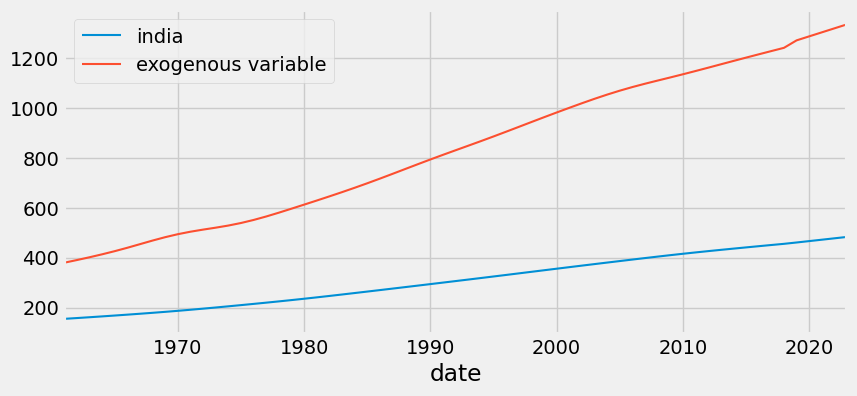

In [ ]:
# Configuração do matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Plota os dados
fig, ax = plt.subplots(figsize=(9, 4))
data['india'].plot(ax=ax, label='india')
data['bangladesh'].plot(ax=ax, label='exogenous variable')
ax.legend();

Train dates : 1961-01-01 00:00:00 --- 2013-01-01 00:00:00  (n=53)
Test dates  : 2014-01-01 00:00:00 --- 2023-01-01 00:00:00  (n=10)


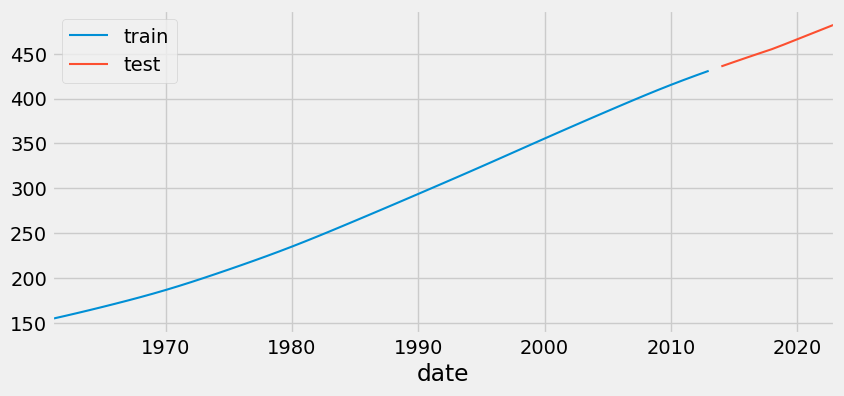

In [ ]:
# Divide dados em treinamento e teste
# Para séries temporais, sempre utilizamos os dados mais recentes para teste
steps = 10
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Plotando os dados
fig, ax=plt.subplots(figsize=(9, 4))
data_train['india'].plot(ax=ax, label='train')
data_test['india'].plot(ax=ax, label='test')
ax.legend();

In [ ]:
# Sklearn e Skforecast
from sklearn.ensemble import RandomForestRegressor

!pip install skforecast

from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures


In [ ]:
# Tunning
# Usara combinacoes aleatorias dos parametros
# ==============================================================================
from skforecast.model_selection import random_search_forecaster
from skforecast.model_selection import TimeSeriesFold
import numpy as np

forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 10, # O valor será substituído durante o tunning,
                 window_features = RollingFeatures(stats=['mean'], window_sizes=10)
             )

# Valores de lag a testar
lags_grid = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Regressor hyperparameters
param_distributions = {'n_estimators': np.arange(start=10, stop=100, step=1, dtype=int),
                       'max_depth': np.arange(start=5, stop=30, step=1, dtype=int)}


# Folds
cv = TimeSeriesFold(
         steps              = steps,
         initial_train_size = len(data_train),
         refit              = True
     )

results = random_search_forecaster(
              forecaster           = forecaster,
              y                    = data.india,
              cv                   = cv,
              lags_grid            = lags_grid,
              param_distributions  = param_distributions,
              n_iter               = 100,
              metric               = 'mean_squared_error',
              return_best          = True,
              random_state         = 123,
              verbose              = False,
              show_progress        = True
          )

results

lags grid:   0%|          | 0/11 [00:00<?, ?it/s]

params grid:   0%|          | 0/100 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'n_estimators': 10, 'max_depth': 25}
  Backtesting metric: 1016.4053935590531


,lags,lags_label,params,mean_squared_error,n_estimators,max_depth
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'n_estimators': 10, 'max_depth': 25}",1016.405394,10,25
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'n_estimators': 12, 'max_depth': 10}",1060.471597,12,10
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","{'n_estimators': 11, 'max_depth': 14}",1066.445019,11,14
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'n_estimators': 11, 'max_depth': 14}",1067.209788,11,14
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","{'n_estimators': 10, 'max_depth': 25}",1074.486021,10,25
...,...,...,...,...,...,...
1095,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'n_estimators': 32, 'max_depth': 8}",1269.295918,32,8
1096,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'n_estimators': 26, 'max_depth': 11}",1275.893464,26,11
1097,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'n_estimators': 27, 'max_depth': 22}",1276.559090,27,22
1098,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'n_estimators': 27, 'max_depth': 13}",1276.559090,27,13


In [ ]:
# Configura e treina um RandomForestRegressor para série temporal
# Os parâmetros foram retirados do melhor modelo encontrado no material de origem
# Para conseguir os melhores parâmetros se faz necessário realizer hyperparameter tunning (verifique artigo original)
forecaster = ForecasterRecursive(
                regressor = RandomForestRegressor(max_depth=25, n_estimators=10, random_state=123),
                lags      = 12,
                window_features = RollingFeatures(stats=['mean'], window_sizes=10)
             )

forecaster.fit(y=data_train['india'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Window features: ['roll_mean_10'] 
Window size: 12 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1961-01-01 00:00:00'), Timestamp('2013-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: YS-JAN 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    25, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-12-03 14:59:38 
Last fit date: 2024-12-03 14:59:38 
Skforecast version: 0.14.0 
Python version: 3.10.12 
Forecaster id: None

In [ ]:
# Faz predição no conjunto de teste
predictions = forecaster.predict(steps=steps)
predictions

,pred
2014-01-01,430.291974
2015-01-01,430.291974
2016-01-01,430.291974
2017-01-01,430.291974
2018-01-01,430.291974
2019-01-01,430.291974
2020-01-01,430.291974
2021-01-01,430.291974
2022-01-01,430.291974
2023-01-01,430.291974


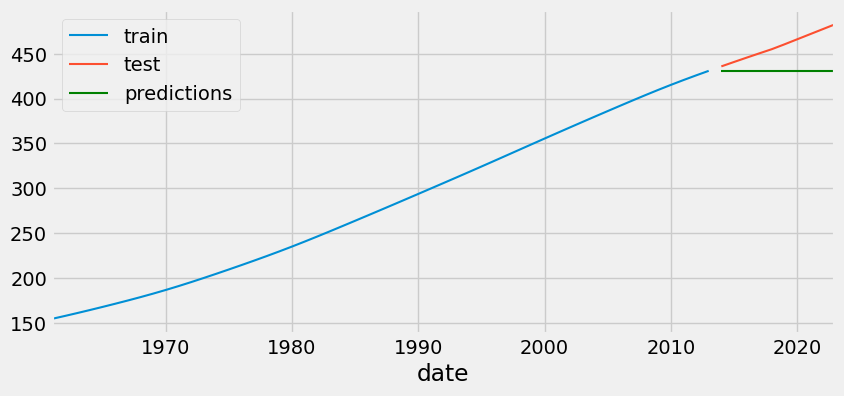

In [ ]:
# Plota a predição, comparando com valores reais
fig, ax=plt.subplots(figsize=(9, 4))
data_train['india'].plot(ax=ax, label='train')
data_test['india'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions', color='green')
ax.legend();
# Aqui fica claro que o skforecast não fez um bom trabalho, mesmo com tunning

In [ ]:
# Vamos tentar com o ARIMA
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.5 MB/s eta 0:00:00


In [ ]:
# O ARIMA vem com um tunning automático, o auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(data_train['india'], trace=True, error_action='ignore', suppress_warnings=True)
# Treina o modelo
model.fit(data_train['india'])
# Previsao
forecast = model.predict(n_periods=len(data_test))
# Converte para um dataframe
forecast = pd.DataFrame(forecast,index = data_test.index,columns=['Prediction'])
forecast

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-336.770, Time=5.19 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-87.200, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-247.066, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-335.026, Time=0.29 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-319.034, Time=0.29 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-340.648, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-333.045, Time=0.29 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=-357.931, Time=0.62 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=-346.965, Time=0.18 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=-345.016, Time=0.74 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=-302.649, Time=0.47 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=-339.011, Time=0.56 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=-347.333, Time=0.55 sec
 ARIMA(5,2,3)(0,0,0)[0]             : A

,Prediction
date,
2014-01-01,435.756037
2015-01-01,440.628619
2016-01-01,445.427895
2017-01-01,450.149733
2018-01-01,454.785494
2019-01-01,459.323530
2020-01-01,463.758446
2021-01-01,468.087431
2022-01-01,472.314124


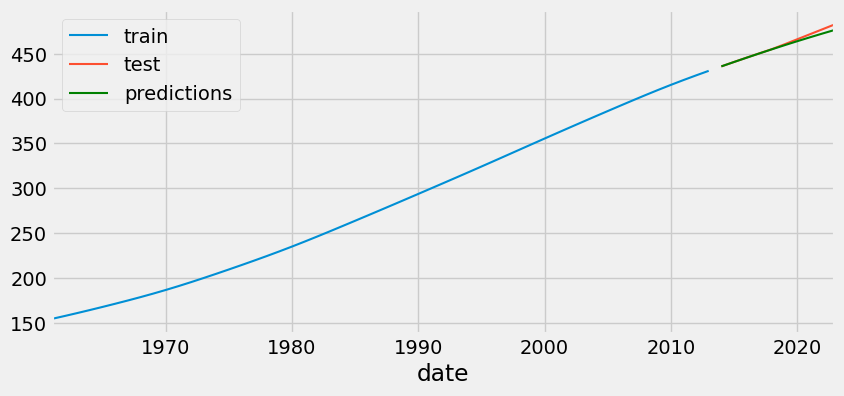

In [ ]:
# Plota a predição, comparando com valores reais
fig, ax=plt.subplots(figsize=(9, 4))
data_train['india'].plot(ax=ax, label='train')
data_test['india'].plot(ax=ax, label='test')
forecast['Prediction'].plot(ax=ax, label='predictions', color='green')
ax.legend();